<a href="https://colab.research.google.com/github/RainXie23/MANE4961---Machine-Learning-for-Engineering-Fall-2025-/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Construct a convolutional neural network model for classifying the CIFAR-10 dataset.
Use the test set of the CIFAR-10 dataset as validation data for the model


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


(a) (64 pts.) Implement the convolutional neural network architecture given below.
i. The first layer is a 2D convolutional layer with 64 filters, each of size (5, 5),
and uses the ReLU activation function. The input shape of the layer should
correspond to the dimensions of the input image.
ii. The second layer is a max pooling layer of size (2, 2).
iii. The third layer is another 2D convolutional layer with 32 filters, each of size
(3, 3), and uses the ReLU activation function.
iv. The fourth layer is another max pooling layer of size (2, 2).
v. The fifth layer is another 2D convolutional layer with 32 filters, each of size (3,
3), and uses the ReLU activation function.
vi. The sixth layer is a flattened layer which converts the output of the previous
layer into a one-dimensional vector.
vii. The seventh layer is a dense layer with 64 neurons and uses the ReLU activation
function.
viii. The eighth and final layer produces estimated probabilities to classify the
CIFAR-10 classes.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.flatten = nn.Flatten()
        # Corrected in_features: (32 channels * 4x4 spatial dimensions after pooling)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Layer 1 (Conv1 + ReLU) followed by Layer 2 (MaxPool)
        x = self.pool(F.relu(self.conv1(x)))
        # Layer 3 (Conv2 + ReLU) followed by Layer 4 (MaxPool)
        x = self.pool2(F.relu(self.conv2(x)))
        # Layer 5 (Conv3 + ReLU)
        x = F.relu(self.conv3(x))
        # Layer 6 (Flatten)
        x = self.flatten(x)
        # Layer 7 (Dense + ReLU)
        x = F.relu(self.fc1(x))
        # Layer 8 (Output Dense Layer)
        x = self.fc2(x) # No ReLU here, CrossEntropyLoss expects raw logits
        return x

classifier = Classifier()

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)

(b) (6 pts.) Calculate and plot the training and validation accuracies of the network
after 10 epochs with a batch size of 64.

Epoch 1: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 2: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 3: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 4: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 5: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 6: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 7: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 8: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 9: Training Accuracy = 10.00%, Validation Accuracy = 10.00%
Epoch 10: Training Accuracy = 10.00%, Validation Accuracy = 10.00%


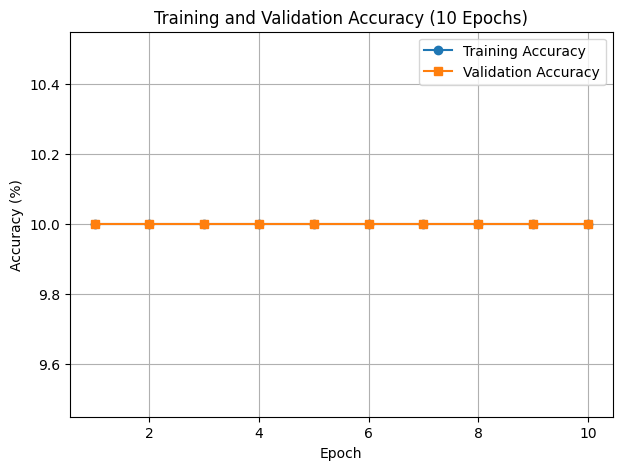

In [5]:
# ----- Part (b): Calculate and plot training & validation accuracies -----
import matplotlib.pyplot as plt

train_accs = []
val_accs = []

# Evaluate accuracy after each epoch (you already trained 10 epochs)
for epoch in range(10):
    # ---- Training accuracy ----
    classifier.eval()
    correct_train, total_train = 0, 0
    with torch.no_grad():
        for inputs, labels in trainloader:
            outputs = classifier(inputs)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    train_acc = 100 * correct_train / total_train
    train_accs.append(train_acc)

    # ---- Validation accuracy ----
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = classifier(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_acc = 100 * correct_val / total_val
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Training Accuracy = {train_acc:.2f}%, Validation Accuracy = {val_acc:.2f}%")

# ---- Plot ----
plt.figure(figsize=(7,5))
plt.plot(range(1, 11), train_accs, 'o-', label='Training Accuracy')
plt.plot(range(1, 11), val_accs, 's-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (10 Epochs)')
plt.legend()
plt.grid(True)
plt.show()

2. Use the Scikit-learn breast cancer Wisconsin dataset and support vector machine classifiers to classify breast cancers. You must use worst compactness, worst concavity, and
worst area features only to perform the classification.


In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

data = load_breast_cancer()

selected_features = ['worst compactness', 'worst concavity', 'worst area']
X = pd.DataFrame(data.data, columns=data.feature_names)[selected_features]
y = data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear')

(a) (15 pts.) What is the accuracy of the classification model with a linear kernel?

In [18]:
accuracy = svc.score(X_test, y_test)
print(accuracy)

0.9415204678362573


(b) (15 pts.) What is the accuracy of the classification model with a radial basis function
kernel with regularization strength parameter, C=2?

In [19]:
svc_rbf = SVC(kernel='rbf', C=2)
svc_rbf.fit(X_train, y_train)

accuracy_rbf = svc_rbf.score(X_test, y_test)
print(accuracy_rbf)

0.9298245614035088
